In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# available dataframes
actions = pd.read_csv("/data/container/actions.csv")
locations = pd.read_csv("/data/container/containerlocationinformation.csv")
handling = pd.read_csv("/data/container/handling.csv", low_memory=False)# dtype of 4 columns is unknown
machines = pd.read_csv("/data/container/machine.csv")
markers = pd.read_csv("/data/container/marker.csv")
entries = pd.read_csv("/data/container/stackentry.csv")
stacks = pd.read_csv("/data/container/stacks.csv")

readme = open("/data/container/readme.txt")
[print(line) for line in readme]
readme.close()

 == Markers + Stacks ==

Define the layout of the yard. All lengths and positions are defined in milimeters for a marker and a stack.

A stack is a specific block on the terminal, and a marker is a place within that stack you can position a container.



Based upon this information we can draw a mark for the yard.



 == Stack entry == 

This is a container placed in a specific stack. A stack entry is placed by a stackcorrection or handling. 

A stack correction is a hard mutation done by someone in the backoffice. A handling is an actual activity done by a crane / stacker / carrier.

All stack entries with a put_mutation and without a pull mutation are currently in the yard.



 == handling == 

Alle movements of containers executed.



 == container location information ==

Shows a bit more information about where a container was or went to. A handling has a from and a to containerlocation information.



 == actions ==

Give information about the container which is transported.



In [3]:
#Er komen alleen NaN waarden voor in de locations dataset 

# Inzichtelijk maken van NULL-waarden in "Handling"
In dit onderdeel zal de data preprocessing plaatsvinden voor een aantal dataframes van de Container dataset. De eerste dataframe die opgeschoond zal worden is 'handling'. Er zal in eerste instantie gekeken worden welke kolommen er gedropped kunnen worden. Hierbij wordt gekeken welke kolommen weinig tot geen waarden bevatten om vervolgens verwijderd te worden van de dataset. Dit geeft mij een overzichtelijker beeld en de gelegenheid om gefocust te werken.

In [4]:
handling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42493 entries, 0 to 42492
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stopoveraction_id              42493 non-null  int64  
 1   endlocation                    0 non-null      float64
 2   id                             42493 non-null  int64  
 3   ended                          26685 non-null  object 
 4   planneddate                    1 non-null      object 
 5   remark                         289 non-null    object 
 6   startlocation                  0 non-null      float64
 7   referenceaction_id             42493 non-null  int64  
 8   location_id                    42493 non-null  int64  
 9   pos                            42243 non-null  float64
 10  visible                        42493 non-null  bool   
 11  priority                       42493 non-null  object 
 12  started                        26698 non-null 

In [5]:
# Kolommen die geen tot heel weinig waarden bevatten: 'endlocation', 'planneddate', 'startlocation', 'debtor_id', 'startrelativemarkerposition', 'endrelativemarkerposition', 'wagon_index', 'loadedwagonposition_id', 'shunt_id', 'reverts_id'.    
handling.isnull().sum()

stopoveraction_id                    0
endlocation                      42493
id                                   0
ended                            15808
planneddate                      42492
remark                           42204
startlocation                    42493
referenceaction_id                   0
location_id                          0
pos                                250
visible                              0
priority                             0
started                          15795
performer_id                     21067
handlingcategory                     0
handlingtype                         0
handlingmethod                       0
deletedon                        32500
autogenerated                        0
debtor_id                        42493
machine_id                       19253
promotiondate                    11468
startrelativemarkerposition      42493
endrelativemarkerposition        42493
wagon_index                      42493
connectedautoprioritize  

<AxesSubplot:>

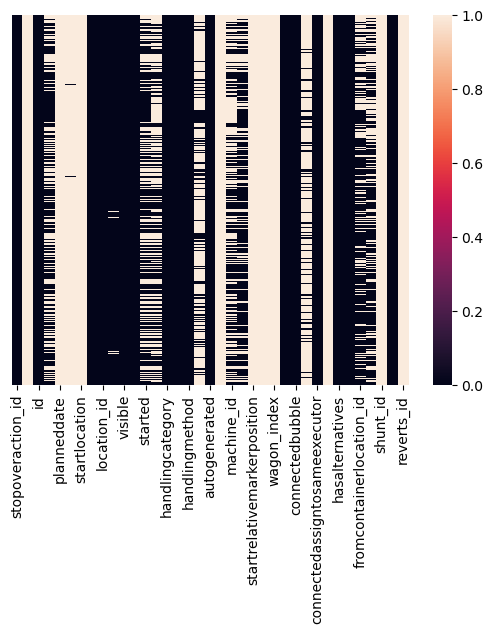

In [6]:
#Visuele weergave ter controle vanuit groter plaatje
sns.heatmap(handling.isnull(), yticklabels=False)

In [7]:
#Verwijderen van de desbtreffende kolommen uit de dataframe
handling.drop(['endlocation', 'planneddate', 'startlocation', 'debtor_id', 'startrelativemarkerposition', 'endrelativemarkerposition', 'wagon_index', 'loadedwagonposition_id', 'shunt_id', 'reverts_id'], axis=1, inplace=True)

In [8]:
handling.head()

,stopoveraction_id,id,ended,remark,referenceaction_id,location_id,pos,visible,priority,started,...,promotiondate,connectedautoprioritize,connectedbubble,connectedreason,connectedassigntosameexecutor,hasalternatives,jobsposition,fromcontainerlocation_id,tocontainerlocation_id,missingagreement
0,3079280,3079277,NaN,NaN,3079278,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,NaN,True
1,3187544,3187541,NaN,NaN,3187542,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,163165176759087541,NaN,3187583.0,True
2,4021400,4021397,NaN,NaN,4021398,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,NaN,True
3,3189746,3189743,NaN,NaN,3189744,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,3189777.0,True
4,4021400,4021404,NaN,NaN,4021402,738495,1.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,NaN,True


Er is nu hierboven een subset aangemaakt van de gecleande 'handling' dataframe door alleen de lege kolommen te verwijderen.

# Kiezen van bruikbare kolommen in 'Handling'

Nu zal er verder gekeken worden welke kolommen in de dataframe nou echt noodzakelijk zijn voor gebruik in het project. Er kunnen namelijk kolommen zijn die volledig bestaan uit gevulde waarden, maar helemaal niet van toepassing zijn in dit project. Er zal dus uitgezocht worden welke kolommen daadwerkelijk meegenomen zullen worden. Hieronder is elke kolom geinspecteerd om een gevalideerde keuze te maken uit de te gebruiken kolommen. 


In [9]:
handling_columns = list(handling.columns)
display(handling_columns)
[print(handling[col].value_counts()) for col in handling_columns]

['stopoveraction_id',
 'id',
 'ended',
 'remark',
 'referenceaction_id',
 'location_id',
 'pos',
 'visible',
 'priority',
 'started',
 'performer_id',
 'handlingcategory',
 'handlingtype',
 'handlingmethod',
 'deletedon',
 'autogenerated',
 'machine_id',
 'promotiondate',
 'connectedautoprioritize',
 'connectedbubble',
 'connectedreason',
 'connectedassigntosameexecutor',
 'hasalternatives',
 'jobsposition',
 'fromcontainerlocation_id',
 'tocontainerlocation_id',
 'missingagreement']

3227228     37
3207050     30
3281204     30
3122918     29
3205079     29
            ..
4769035      1
4768394      1
4768399      1
4768404      1
12194422     1
Name: stopoveraction_id, Length: 13290, dtype: int64
3079277     1
7495490     1
7490304     1
7492986     1
7773392     1
           ..
12953489    1
11239542    1
3886937     1
5818063     1
17755289    1
Name: id, Length: 42493, dtype: int64
2021-09-17 19:59:00.476511    3247
2021-09-22 16:30:34.993232      45
2021-09-17 19:59:18.135758       4
2021-09-24 15:16:55.545904       3
2021-09-17 11:31:30.080643       2
                              ... 
2021-09-30 12:40:21.729193       1
2021-09-24 15:04:09.401207       1
2021-09-24 18:35:42.883310       1
2021-09-24 14:48:15.678544       1
2021-10-17 08:04:35.015731       1
Name: ended, Length: 22997, dtype: int64
                                                                                   50
VEO*LIVB52134400*TL                                                           

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Naar aanleiding van de uitgevoerde for loop hierboven. Heb ik de kolommen kunnen vinden die voor ons bruikbaar zijn. Dit zijn de kolommen: 'fromcontainerlocation_id', 'tocontainerlocation_id', 'started', 'ended', 'handlingtype'. Deze kolommen worden hieronder verder bij elkaar verwerkt in een subset van de originele dataframe. 

In [10]:
handling_subset = handling.loc[:, ['fromcontainerlocation_id', 'tocontainerlocation_id', 'started', 'ended', 'handlingtype']]
display(handling_subset)



,fromcontainerlocation_id,tocontainerlocation_id,started,ended,handlingtype
0,NaN,NaN,NaN,NaN,IN
1,NaN,3187583.0,NaN,NaN,OUT
2,NaN,NaN,NaN,NaN,IN
3,NaN,3189777.0,NaN,NaN,OUT
4,NaN,NaN,NaN,NaN,OUT
...,...,...,...,...,...
42488,17757271.0,17757712.0,2021-10-15 16:04:51.572550,2021-10-15 16:05:39.071536,INTERNAL
42489,17758165.0,17758599.0,2021-10-15 16:06:56.760897,2021-10-15 16:07:14.592198,INTERNAL
42490,17759392.0,17760125.0,2021-10-15 16:09:04.045943,2021-10-15 16:10:09.952992,INTERNAL
42491,17760375.0,17760862.0,2021-10-15 16:11:14.036448,2021-10-15 16:11:32.566027,INTERNAL


Hieronder zijn alleen de verschillen weergegeven van row numbers: 42488, 42489, 42490, 42491. Er wordt verder gekeken of de rest van de rows in de kolommen 'ended' en 'started' met elkaar kunnen vergelijken. De code dat gebruikt werd, gaf telkens errors aan zelfs nadat het is geconferteerd door middel van 'pd.Timestamp'. De andere codes (na 3 soorten pogingen) zijn onder de output van deze code te zien. 

In [11]:
handling_subset = {'ended': [pd.Timestamp('2021-10-15 16:05:39.071536'), pd.Timestamp('2021-10-15 16:07:14.592198'), pd.Timestamp('2021-10-15 16:10:09.952992'), pd.Timestamp('2021-10-15 16:11:32.566027')],
        'started': [pd.Timestamp('2021-10-15 16:04:51.572550'), pd.Timestamp('2021-10-15 16:06:56.760897'), pd.Timestamp('2021-10-15 16:09:04.045943'), pd.Timestamp('2021-10-15 16:11:14.036448')]}

# test dataframe; de kolommen moeten in een datetime format
handling_subset = pd.DataFrame(handling_subset)

# toevoegen van kolom totale duur van een handeling
handling_subset['Duration'] = (handling_subset.ended - handling_subset.started)

# maken van een kolom 'totale duur van een handeling in uren', als een float type
handling_subset['Duration_hours'] = (handling_subset.ended - handling_subset.started) / pd.Timedelta(hours=1)

# maken van een kolom 'totale duur van een handeling in minuten', as a float type
handling_subset['Duration_mins'] = (handling_subset.ended - handling_subset.started) / pd.Timedelta(minutes=1)

display(handling_subset)

#(handling_subset.ended - handling_subset.started).dt.total_seconds()

#handling_subset['diff'] = handling_subset[int('ended')] - handling_subset[int('started')]

,ended,started,Duration,Duration_hours,Duration_mins
0,2021-10-15 16:05:39.071536,2021-10-15 16:04:51.572550,0 days 00:00:47.498986,0.013194,0.791650
1,2021-10-15 16:07:14.592198,2021-10-15 16:06:56.760897,0 days 00:00:17.831301,0.004953,0.297188
2,2021-10-15 16:10:09.952992,2021-10-15 16:09:04.045943,0 days 00:01:05.907049,0.018308,1.098451
3,2021-10-15 16:11:32.566027,2021-10-15 16:11:14.036448,0 days 00:00:18.529579,0.005147,0.308826


Code attempt 1:

In [12]:
handling_subset['ended'] = pd.to_datetime(handling_subset['ended'], unit='D')
handling_subset['started'] = pd.to_datetime(handling_subset['started'], unit='D')
display(handling_subset.tail())
handling_subset.info()

,ended,started,Duration,Duration_hours,Duration_mins
0,2021-10-15 16:05:39.071536,2021-10-15 16:04:51.572550,0 days 00:00:47.498986,0.013194,0.791650
1,2021-10-15 16:07:14.592198,2021-10-15 16:06:56.760897,0 days 00:00:17.831301,0.004953,0.297188
2,2021-10-15 16:10:09.952992,2021-10-15 16:09:04.045943,0 days 00:01:05.907049,0.018308,1.098451
3,2021-10-15 16:11:32.566027,2021-10-15 16:11:14.036448,0 days 00:00:18.529579,0.005147,0.308826


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   ended           4 non-null      datetime64[ns] 
 1   started         4 non-null      datetime64[ns] 
 2   Duration        4 non-null      timedelta64[ns]
 3   Duration_hours  4 non-null      float64        
 4   Duration_mins   4 non-null      float64        
dtypes: datetime64[ns](2), float64(2), timedelta64[ns](1)
memory usage: 288.0 bytes


Code attempt 2:

In [13]:
handling_subset['Duration'] = handling_subset['ended'].sub(handling_subset['started'], axis = 0)


Code attempt 3:

In [14]:
for ind, row in handling.iterrows():
    handling_subset.loc[ind, 'Duration'] = row['ended'] / row['started']

TypeError: unsupported operand type(s) for /: 'str' and 'str'

# NaN-waarden eruit halen en/of vullen in 'Handling'

In dit onderdeel wordt de dataset geanalyseerd om bruikbare kolommen in de 'handling' dataset in kaart te brengen. Er zijn namelijk erg veel kolommen die geen waarden bevatten, maar ook helemaal niet nodig/nuttig zijn voor onze scope. Om gefocust en overzichtelijk te werken, zijn de kolommen gekozen met de .loc[] functie. Er worden een aantal methoden/technieken toegepast om de bruikbare kolommen in 'handling' in kaart te brengen. 


Kijken wat belangrijke kolommen zijn: fromcontainerlocation_id, tocontainerlocation_id, started (parsen naar timestamps), ended (parsen naar timestamps), handlingmethod, extra kolom 'duration'(ended - started).





In [15]:
handling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42493 entries, 0 to 42492
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stopoveraction_id              42493 non-null  int64  
 1   id                             42493 non-null  int64  
 2   ended                          26685 non-null  object 
 3   remark                         289 non-null    object 
 4   referenceaction_id             42493 non-null  int64  
 5   location_id                    42493 non-null  int64  
 6   pos                            42243 non-null  float64
 7   visible                        42493 non-null  bool   
 8   priority                       42493 non-null  object 
 9   started                        26698 non-null  object 
 10  performer_id                   21426 non-null  float64
 11  handlingcategory               42493 non-null  object 
 12  handlingtype                   42493 non-null 

In [16]:
display(handling)

,stopoveraction_id,id,ended,remark,referenceaction_id,location_id,pos,visible,priority,started,...,promotiondate,connectedautoprioritize,connectedbubble,connectedreason,connectedassigntosameexecutor,hasalternatives,jobsposition,fromcontainerlocation_id,tocontainerlocation_id,missingagreement
0,3079280,3079277,NaN,NaN,3079278,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,NaN,True
1,3187544,3187541,NaN,NaN,3187542,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,163165176759087541,NaN,3187583.0,True
2,4021400,4021397,NaN,NaN,4021398,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,NaN,True
3,3189746,3189743,NaN,NaN,3189744,738495,0.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,3189777.0,True
4,4021400,4021404,NaN,NaN,4021402,738495,1.0,False,LOW,NaN,...,NaN,False,True,NaN,False,False,0,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42488,17674856,17757267,2021-10-15 16:05:39.071536,NaN,17674856,738495,1.0,True,HIGH,2021-10-15 16:04:51.572550,...,2021-10-15 16:04:42.355644,False,True,NaN,False,False,163431388235500000,17757271.0,17757712.0,False
42489,17676955,17758163,2021-10-15 16:07:14.592198,NaN,17676955,738495,1.0,True,HIGH,2021-10-15 16:06:56.760897,...,2021-10-15 16:06:28.341775,False,True,NaN,False,False,163431398834100000,17758165.0,17758599.0,False
42490,17674242,17759383,2021-10-15 16:10:09.952992,NaN,17674242,738495,1.0,True,HIGH,2021-10-15 16:09:04.045943,...,2021-10-15 16:08:41.331287,False,True,NaN,False,False,163431412133100000,17759392.0,17760125.0,False
42491,17673798,17760365,2021-10-15 16:11:32.566027,NaN,17673798,738495,1.0,True,HIGH,2021-10-15 16:11:14.036448,...,2021-10-15 16:10:37.692229,False,True,NaN,False,False,163431423769200000,17760375.0,17760862.0,False


# Inzichtelijk maken van NULL-waarden in "locations"
In dit onderdeel zal de data preprocessing plaatsvinden voor een aantal datasets. De eerste dataset die opgeschoond zal worden is 'locations'. Er zal in eerste instantie gekeken worden welke kolommen er gedropped kunnen worden. Hierbij wordt gekeken welke kolommen weinig tot geen waarden bevattenom vervolgens verwijderd te worden van de dataset. Dit geeft mij een een overzichtelijker beeld en de gelegenheid om gefocust te werken.  



Hieronder worden een aantal technieken uitgevoerd om het aantal NULL-waarden per kolom in 'locations' te achterhalen.

In [18]:
locations.isnull().sum()

dtype                                0
id                                   0
cachedstring                     11778
stackentitytrainconnection       72007
truckvisit_id                    50539
bay                              60230
tier                             60230
row                              60230
relativeyardmarkerposition       52602
marker_id                        51770
stackentity_id                   46864
stackentry_id                    54823
yardregion_id                    72007
markerheight                     54766
stackentitytrainconnection_id    72007
loadedwagonposition_id           72007
loadingtask_id                   72007
location_id                      72007
shunt_id                         72007
truckpoint_id                    61816
dtype: int64

Hierboven hebben we een beeld gekregen van hoeveel NULL-waarden (NaN) er voorkomen per kolom in de 'locations' dataset. Aangezien we de dataset nog niet helemaal hebben ingezien en er zeker van willen zijn of er daadwerkelijk wel of geen NULL-waarden in de kolommen voorkomen, voeren we de volgende stap uit:

In [19]:
# Checken of er daadwerkelijk NULL-waarden zijn
locations.isnull().any()

dtype                            False
id                               False
cachedstring                      True
stackentitytrainconnection        True
truckvisit_id                     True
bay                               True
tier                              True
row                               True
relativeyardmarkerposition        True
marker_id                         True
stackentity_id                    True
stackentry_id                     True
yardregion_id                     True
markerheight                      True
stackentitytrainconnection_id     True
loadedwagonposition_id            True
loadingtask_id                    True
location_id                       True
shunt_id                          True
truckpoint_id                     True
dtype: bool

In [20]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72007 entries, 0 to 72006
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dtype                          72007 non-null  object 
 1   id                             72007 non-null  int64  
 2   cachedstring                   60229 non-null  object 
 3   stackentitytrainconnection     0 non-null      float64
 4   truckvisit_id                  21468 non-null  float64
 5   bay                            11777 non-null  float64
 6   tier                           11777 non-null  float64
 7   row                            11777 non-null  float64
 8   relativeyardmarkerposition     19405 non-null  object 
 9   marker_id                      20237 non-null  float64
 10  stackentity_id                 25143 non-null  float64
 11  stackentry_id                  17184 non-null  float64
 12  yardregion_id                  0 non-null     

<AxesSubplot:>

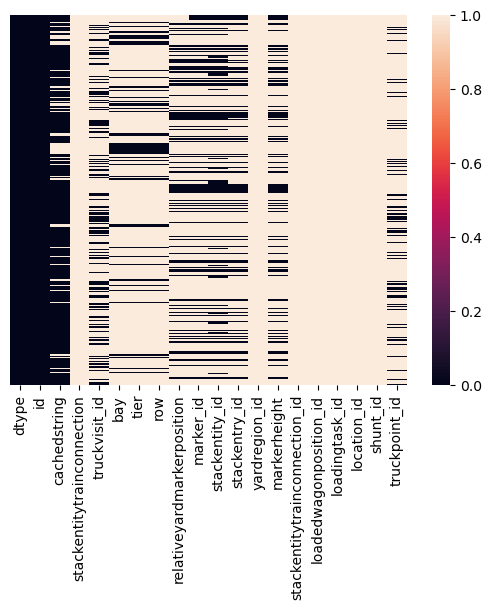

In [21]:
sns.heatmap(locations.isnull(), yticklabels=False)

In [22]:
#Cleaned locations dataset with removed NaN columns
locations.drop(['stackentitytrainconnection_id', 'loadedwagonposition_id', 'location_id', 'shunt_id'], axis=1, inplace=True)

In [23]:
locations.head()

,dtype,id,cachedstring,stackentitytrainconnection,truckvisit_id,bay,tier,row,relativeyardmarkerposition,marker_id,stackentity_id,stackentry_id,yardregion_id,markerheight,loadingtask_id,truckpoint_id
0,TruckContainerLocationInformation,3079301,xx-382-f-Rab transport account,NaN,3079299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TruckContainerLocationInformation,3079335,xx-382-f-Rab transport account,NaN,3079299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TruckContainerLocationInformation,3157137,test1-Rab transport account,NaN,3157136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TruckContainerLocationInformation,3157167,test1-Rab transport account,NaN,3157136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TruckContainerLocationInformation,3157168,test1-Rab transport account,NaN,3157136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Einde verwijderen van kolommen met NaN-waarden in de datasets

# Typen NULL-waarden inzichtelijk maken

In [24]:
missing_value=["NaN", np.nan]
handling = pd.read_csv("/data/container/handling.csv", na_values=missing_value)

/tmp/ipykernel_29987/685411027.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  handling = pd.read_csv("/data/container/handling.csv", na_values=missing_value)


In [25]:
handling.isnull().sum()

stopoveraction_id                    0
endlocation                      42493
id                                   0
ended                            15808
planneddate                      42492
remark                           42204
startlocation                    42493
referenceaction_id                   0
location_id                          0
pos                                250
visible                              0
priority                             0
started                          15795
performer_id                     21067
handlingcategory                     0
handlingtype                         0
handlingmethod                       0
deletedon                        32500
autogenerated                        0
debtor_id                        42493
machine_id                       19253
promotiondate                    11468
startrelativemarkerposition      42493
endrelativemarkerposition        42493
wagon_index                      42493
connectedautoprioritize  

In [26]:
display(entries.head())
print(entries.info())

,id,stack_id,rowrange,depth,heightrange,terminalstopoveraction_id,put_handling_id,put_correction_id,pull_handling_id,pull_correction_id,yardmovehandling_id,container_number,container_relative_marker_position,container_height,marker_id,reachstacker_moves,crane_moves,locationinformation_id,straddlecarrier_moves
0,3920629,2352069,"[10,12202)",0,"[0,2896)",3122918,3920475.0,NaN,5347663.0,NaN,NaN,NaN,1,0,NaN,0.0,0.0,3920628.0,0.0
1,4159223,2351021,"[12202,24394)",0,"[0,2896)",3119380,4159212.0,NaN,3119385.0,NaN,NaN,NaN,1,0,NaN,0.0,0.0,4159222.0,0.0
2,8281557,2352127,"[0,1)",0,"[0,1)",8223917,NaN,8281555.0,8238361.0,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN
3,4146707,2351245,"[61002,73194)",0,"[0,2621)",3106620,4146688.0,NaN,6423134.0,NaN,NaN,NaN,1,0,NaN,0.0,0.0,4146706.0,0.0
4,5620843,2387709,"[0,1)",0,"[0,1)",5563630,5614146.0,NaN,5563627.0,NaN,NaN,NaN,1,0,NaN,0.0,0.0,5620842.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18169 entries, 0 to 18168
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  18169 non-null  int64  
 1   stack_id                            18169 non-null  int64  
 2   rowrange                            18169 non-null  object 
 3   depth                               18169 non-null  int64  
 4   heightrange                         18169 non-null  object 
 5   terminalstopoveraction_id           18169 non-null  int64  
 6   put_handling_id                     16226 non-null  float64
 7   put_correction_id                   1943 non-null   float64
 8   pull_handling_id                    11950 non-null  float64
 9   pull_correction_id                  4517 non-null   float64
 10  yardmovehandling_id                 0 non-null      float64
 11  container_number                    0 non

In [27]:
display(actions.head())
print(actions.info())

,stopid,status,isemptycontainer,bookingidentifier,bookinginfo_containertype,bookinginfo_carrier,bookinginfo_customer,gatein,gateout,previousactiontype,previoussta,nextactiontype,nextstd
0,3391542,NEXT,True,24550-1,20DV,Containership CMA GmbH,Containership,NaN,NaN,NaN,NaN,ExternalAction,NaN
1,3187432,NEXT,True,23141-1,40HC,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
2,5094163,FINISHED,False,26181-1,45HW,Containership CMA,Containership,2021-09-22 13:33:59.886418,2021-09-27 12:56:40.578678,ExternalAction,NaN,BargeTransportAction,2021-09-26 17:00:00.000000
3,3196883,NEXT,True,23244-1,40HW,Containership CMA GmbH,Containership,NaN,NaN,NaN,NaN,ExternalAction,NaN
4,3187544,NEXT,True,23144-1,20DV,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13700 entries, 0 to 13699
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   stopid                     13700 non-null  int64 
 1   status                     13700 non-null  object
 2   isemptycontainer           13700 non-null  bool  
 3   bookingidentifier          13700 non-null  object
 4   bookinginfo_containertype  13696 non-null  object
 5   bookinginfo_carrier        13654 non-null  object
 6   bookinginfo_customer       13252 non-null  object
 7   gatein                     8317 non-null   object
 8   gateout                    5062 non-null   object
 9   previousactiontype         13228 non-null  object
 10  previoussta                3619 non-null   object
 11  nextactiontype             13129 non-null  object
 12  nextstd                    4210 non-null   object
dtypes: bool(1), int64(1), object(11)
memory usage: 1.3+ MB
None


In [28]:
display(actions[actions['bookinginfo_carrier'] == 'MEDITE UK LTD'])
display(actions[actions['isemptycontainer'] == True])

,stopid,status,isemptycontainer,bookingidentifier,bookinginfo_containertype,bookinginfo_carrier,bookinginfo_customer,gatein,gateout,previousactiontype,previoussta,nextactiontype,nextstd
1,3187432,NEXT,True,23141-1,40HC,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
4,3187544,NEXT,True,23144-1,20DV,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
6,4933070,FINISHED,True,26031-1,40HC,MEDITE UK LTD,MEDITE UK LTD,2021-09-22 15:55:03.611000,NaN,BargeTransportAction,2021-09-22 18:00:00.000000,PairAction,NaN
10,8146273,FINISHED,True,27612-236,40HC,MEDITE UK LTD,MEDITE UK LTD,2021-09-30 06:33:03.455678,NaN,BargeTransportAction,2021-09-29 17:00:00.000000,ExternalAction,NaN
15,3187566,NEXT,True,23145-1,20DV,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13684,5760514,NOT_STARTED,True,26473-1,40DV,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,ExternalAction,NaN,NaN,NaN
13691,3174933,IN_PROGRESS,True,23050-306,40HC,MEDITE UK LTD,MEDITE UK LTD,2021-09-04 18:46:40.993000,NaN,ExternalAction,NaN,NaN,NaN
13693,3163489,IN_PROGRESS,True,23050-37,20DV,MEDITE UK LTD,MEDITE UK LTD,2021-07-26 16:02:10.627000,NaN,ExternalAction,NaN,NaN,NaN
13694,3174619,IN_PROGRESS,True,23050-298,40HC,MEDITE UK LTD,MEDITE UK LTD,2021-09-04 18:35:39.107000,NaN,ExternalAction,NaN,NaN,NaN


,stopid,status,isemptycontainer,bookingidentifier,bookinginfo_containertype,bookinginfo_carrier,bookinginfo_customer,gatein,gateout,previousactiontype,previoussta,nextactiontype,nextstd
0,3391542,NEXT,True,24550-1,20DV,Containership CMA GmbH,Containership,NaN,NaN,NaN,NaN,ExternalAction,NaN
1,3187432,NEXT,True,23141-1,40HC,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
3,3196883,NEXT,True,23244-1,40HW,Containership CMA GmbH,Containership,NaN,NaN,NaN,NaN,ExternalAction,NaN
4,3187544,NEXT,True,23144-1,20DV,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
6,4933070,FINISHED,True,26031-1,40HC,MEDITE UK LTD,MEDITE UK LTD,2021-09-22 15:55:03.611000,NaN,BargeTransportAction,2021-09-22 18:00:00.000000,PairAction,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13695,17700977,IN_PROGRESS,True,31333-1,20DV,OOCL,OOCL,2021-10-15 16:49:27.737697,NaN,BargeTransportAction,2021-10-15 11:00:00.000000,NaN,NaN
13696,14337159,IN_PROGRESS,True,30071-195,40HC,MEDITE UK LTD,MEDITE UK LTD,2021-10-11 20:57:18.689396,NaN,BargeTransportAction,2021-10-10 20:00:00.000000,NaN,NaN
13697,17700905,NOT_STARTED,True,31105-11,45HW,B.G. Freight Line B.V.,BGF,NaN,NaN,BargeTransportAction,NaN,NaN,NaN
13698,3165415,IN_PROGRESS,True,23051-25,40HC,Containership CMA GmbH,Containership,2021-08-10 11:00:39.813000,NaN,ExternalAction,NaN,NaN,NaN


In [29]:
# status 'FINISHED' and gateout not being NaN come together
display(actions[actions['gateout'].notna()].head())
display(actions[actions['gatein'].isna()].head())

,stopid,status,isemptycontainer,bookingidentifier,bookinginfo_containertype,bookinginfo_carrier,bookinginfo_customer,gatein,gateout,previousactiontype,previoussta,nextactiontype,nextstd
2,5094163,FINISHED,False,26181-1,45HW,Containership CMA,Containership,2021-09-22 13:33:59.886418,2021-09-27 12:56:40.578678,ExternalAction,NaN,BargeTransportAction,2021-09-26 17:00:00.000000
5,3110298,FINISHED,False,22691-3,45HW,Containership CMA GmbH,Containership,2021-08-26 14:12:19.680000,2021-09-17 11:12:17.473374,ExternalAction,NaN,BargeTransportAction,2021-09-16 17:00:00.000000
8,17764057,FINISHED,True,31157-1,45HW,Containership CMA,Containership,NaN,2021-10-17 07:55:48.797593,PairAction,NaN,ExternalAction,NaN
11,3124050,FINISHED,False,22986-18,40HW,Containership CMA GmbH,Containership,2021-09-01 15:37:44.083000,2021-09-30 11:59:12.893813,BargeTransportAction,2021-08-29 05:00:00.000000,ExternalAction,NaN
13,9387769,FINISHED,True,28356-1,40HC,ACL,ACL,NaN,2021-09-30 13:41:15.353152,PairAction,NaN,ExternalAction,NaN


,stopid,status,isemptycontainer,bookingidentifier,bookinginfo_containertype,bookinginfo_carrier,bookinginfo_customer,gatein,gateout,previousactiontype,previoussta,nextactiontype,nextstd
0,3391542,NEXT,True,24550-1,20DV,Containership CMA GmbH,Containership,NaN,NaN,NaN,NaN,ExternalAction,NaN
1,3187432,NEXT,True,23141-1,40HC,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
3,3196883,NEXT,True,23244-1,40HW,Containership CMA GmbH,Containership,NaN,NaN,NaN,NaN,ExternalAction,NaN
4,3187544,NEXT,True,23144-1,20DV,MEDITE UK LTD,MEDITE UK LTD,NaN,NaN,NaN,NaN,ExternalAction,NaN
8,17764057,FINISHED,True,31157-1,45HW,Containership CMA,Containership,NaN,2021-10-17 07:55:48.797593,PairAction,NaN,ExternalAction,NaN
